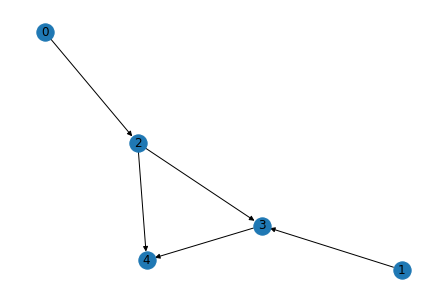

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the number of nodes and the probability of edge creation
num_nodes = 5
prob_edge_creation = 0.5

# Generate a random graph using the fast_gnp_random_graph function
random_graph = nx.dense_gnm_random_graph(num_nodes , 5)

# Draw the random graph
nx.draw(random_graph, with_labels=True, arrows=True)
plt.show()

In [3]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 2784, done.
remote: Counting objects: 100% (2784/2784), done.
remote: Compressing objects: 100% (522/522), done.
remote: Total 2784 (delta 2338), reused 2696 (delta 2250), pack-reused 0
Receiving objects: 100% (2784/2784), 11.32 MiB | 3.38 MiB/s, done.
Resolving deltas: 100% (2338/2338), done.
Updating files: 100% (2569/2569), done.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
from Eunomia.ssb import * 
from Eunomia.graph_utils import * 
from docplex.mp.model import Model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
pyro.set_rng_seed(1)

In [5]:
def remove_bidir_arcs(graph):
    graph2 = nx.DiGraph()
    for x,y in graph.edges():
        if not (y,x) in graph2.edges():
            if not all(i in y for i in x):
                graph2.add_edge(x,y)
    return graph2


def sample_random_graph(n, degree, method = "gnp", **kwargs):
    subsets = [tuple(i) for i in generate_additive_theta(n, degree)]
    methods = ["gnp"]
    if method not in methods:
        print("Unknown method")
        return None
    if method == "gnp":
        if not "p" in kwargs:
            print("missing param p")
            return None
        random_graph = nx.fast_gnp_random_graph(len(subsets), kwargs["p"], directed = True)
        random_graph = nx.relabel_nodes(random_graph, {i: label for i, label in enumerate(subsets)})
        random_graph = remove_bidir_arcs(random_graph)
    return random_graph

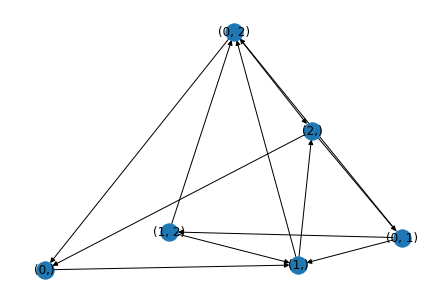

In [6]:
graph = sample_random_graph(3,2,p=0.6)
nx.draw(graph, with_labels=True, arrows=True)
plt.show()

In [8]:
def get_all_pairs(L):
    pairs = []
    for i in range(len(L)):
        for j in range(i+1, len(L)):
            pairs.append((L[i], L[j]))
    return pairs

In [9]:
class SSB_Model:
    def __init__(self, items, theta = None, phi=None, degree = 1):
        self.items = items
        if not theta and not phi:
            theta = [tuple(i) for i in generate_additive_theta(len(items), degree)]
            phi = get_all_pairs(theta)
        self.theta = theta
        self.phi = phi
        self.solved = False
        
        self.r_theta = 0
        self.r_phi = 0
        self.eps = []
        
        self.mdl = Model(name='SSB_Model')

        self.w_vars = {}
        for k in self.theta:
            self.w_vars[k] = self.mdl.continuous_var(name="w_"+str(set(k)),lb =-np.infty, ub = np.infty)
            self.r_theta =  self.r_theta + self.mdl.abs(self.w_vars[k])
             
        self.b_vars = {}      
        for k in self.phi:
            self.b_vars[k] = self.mdl.continuous_var(name="b_("+str(set(k[0]))+"->"+str(set(k[1]))+")",lb =-np.infty,ub = np.infty)
            self.r_phi =  self.r_phi + self.mdl.abs(self.b_vars[k])

    
    def project(self, x, y):
        s = 0
        for k in self.theta:
            if all(i in x for i in k):
                s += self.w_vars[k]
            if all(i in y for i in k):
                s -= self.w_vars[k]
                
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                s += self.b_vars[(A,B)]
            if all(i in x for i in B) and all(i in y for i in A):
                s -= self.b_vars[(A,B)]
        return s
    
    def fit(self, prf):
        self.prf = prf
        edges = []
        self.eps = []
        for x,y in self.prf:
            if (set(y),set(x)) in edges:
                continue
            edges.append((set(x),set(y)))
            eps = self.mdl.continuous_var(name=f"eps_({set(x)}_{set(y)})",lb =0,ub = np.infty)
            cst = self.mdl.add_constraint(self.project(x,y) >= 1 - eps, ctname = f"c_({set(x)}_{set(y)})")
            self.eps.append(eps)
        self.mdl.minimize_static_lex([self.mdl.sum(self.eps), self.r_theta + 100*self.r_phi])
        s = self.mdl.solve(log_output = False)
        if s:
            self.solved = True
        return s
    
    def predict(self, x,y):
        if not self.solved:
            print("PL not solved")
            return None
        s = 0
        for k in self.theta:
            if all(i in x for i in k):
                s += self.w_vars[k].solution_value
            if all(i in y for i in k):
                s -= self.w_vars[k].solution_value
                
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                s += self.b_vars[(A,B)].solution_value
            if all(i in x for i in B) and all(i in y for i in A):
                s -= self.b_vars[(A,B)].solution_value
        return s
    
    def n_ssb_vars(self):
        return sum([1 if np.abs(self.b_vars[i].solution_value) > 0 else 0 for i in self.b_vars])

    def n_w_vars(self):
        return sum([1 if np.abs(self.w_vars[i].solution_value) > 0 else 0 for i in self.w_vars])
    
    def ratio_of_representation(self):
        return 1 - sum([1 if i.solution_value > 0 else 0 for i in self.eps]) / len(self.eps)
    
    def print_model(self):
        print("% representation =", self.ratio_of_representation())
        for x in self.w_vars:
            if (self.w_vars[x].solution_value != 0):
                print(f"w_{x}: {self.w_vars[x].solution_value}")
        
        for x,y in self.b_vars:
            if self.b_vars[(x,y)].solution_value != 0:
                print(f"b_({x}->{y}): {self.b_vars[(x,y)].solution_value}")
            

In [10]:
n = 7
items = np.arange(n)

In [11]:
graph = sample_random_graph(n, 6, p=0.3)
prf = list(graph.edges())

In [12]:
model = SSB_Model(items, degree =2)
model.fit(prf)

docplex.mp.solution.SolveSolution(obj=2526.97,values={w_{0}:0.390126,_ab..

In [42]:
model.print_model()

% representation = 0.2897243107769424
w_(0,): -1.9218526472837085
w_(1,): -0.8123804171253941
w_(2,): -0.8493212650331594
w_(3,): -1.3871547298406293
w_(4,): 0.01096497968123411
w_(5,): 0.1594911276393449
w_(6,): 0.6049787773324591
w_(0, 1): 2.3378921792946468
w_(0, 2): 0.29621477700244314
w_(0, 3): 0.7411791600766329
w_(0, 4): 0.40890834759017025
w_(0, 5): 0.42974239015709814
w_(0, 6): -0.5275688787153004
w_(1, 2): 0.5032861025034728
w_(1, 3): -0.052844175357717564
w_(1, 4): 0.11444218911423146
w_(1, 5): 0.1823975421021931
w_(1, 6): 0.01493179726205128
w_(2, 3): 0.8825037284165201
w_(2, 4): -0.25915914249185856
w_(2, 5): 0.08443261846007277
w_(2, 6): 1.0749765542898009
w_(3, 4): 0.4848469814892253
w_(3, 5): -0.1607683546252949
w_(3, 6): 0.6998612356383905
w_(4, 5): 1.0460500862144086
w_(4, 6): -0.5656858135549795
w_(5, 6): -0.925808860024858
b_((0,)->(1,)): 0.23536098219543267
b_((0,)->(2,)): 0.18242001345128175
b_((0,)->(3,)): 0.7568725693059343
b_((0,)->(4,)): 1.4986558405345451
b_(

In [43]:
model.n_w_vars()

28

In [44]:
model.n_ssb_vars()

378

In [15]:
from tqdm.notebook import tqdm

In [ ]:
data = {
    "p":[],
    "n":[],
    "d_g":[],
    "d_m":[],
    "%r":[],
    "n_v_w":[],
    "n_v_b":[]
}

for p in np.linspace(0.3, 1, 10):
    for n in range(5,8):
        for d_g in range(1,min(n,7)):
            for d_m in range(1,min(d_g+1, 7)):
                for iteration in range(100):
                    print(".", end = "")
                    if iteration % 10 == 0:
                        print("|", end = "")
                    items = np.arange(n)
                    graph = sample_random_graph(n, d_g, p=p)
                    model = SSB_Model(items,degree=d_m)
                    prf = list(graph.edges())
                    if len(prf) == 0:
                        continue
                    model.fit(prf)
                    data["p"].append(p)
                    data["n"].append(n)
                    data["d_g"].append(d_g)
                    data["d_m"].append(d_m)
                    data["%r"].append(model.ratio_of_representation())
                    data["n_v_w"].append(model.n_w_vars())
                    data["n_v_b"].append(model.n_ssb_vars())
        df = pd.DataFrame(data)
        df.to_csv(f"ROADEF_TESTS_2/test_n{n}_p{p}.csv")
        print("\n ===========")
        print(df.groupby(["d_g","d_m"]).mean().reset_index()[["d_g", "d_m", "%r"]])
        print("===========")

.|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|........

In [ ]:
data = {
    "p":[],
    "n":[],
    "d_g":[],
    "d_m":[],
    "%r":[],
    "n_v_w":[],
    "n_v_b":[]
}
n = 10
for p in np.linspace(0.3, 1, 10):
    for d_g in range(1,10):
        for d_m in range(1,min(d_g+1, 7)):
            for iteration in range(100):
                print(".", end = "")
                if iteration % 10 == 0:
                    print("|", end = "")
                items = np.arange(n)
                graph = sample_random_graph(n, d_g, p=p)
                model = SSB_Model(items,degree=d_m)
                prf = list(graph.edges())
                if len(prf) == 0:
                    continue
                model.fit(prf)
                data["p"].append(p)
                data["n"].append(n)
                data["d_g"].append(d_g)
                data["d_m"].append(d_m)
                data["%r"].append(model.ratio_of_representation())
                data["n_v_w"].append(model.n_w_vars())
                data["n_v_b"].append(model.n_ssb_vars())
    df = pd.DataFrame(data)
    df.to_csv(f"ROADEF_TESTS_2/test_n{n}_p{p}.csv")
    print("\n ===========")
    print(df.groupby(["d_g","d_m"]).mean().reset_index()[["d_g", "d_m", "%r"]])
    print("===========")

- Introduction SSB.
- SSB généralise une fonction additive.
- Explique comment décomposer SSB.
- Nouvelle formulation de SSB.
- Une fonction additive avec interactions représenter n'importe quel graph sans cycles sur des sous ensembles.
- Si y'a des cycles, il suffit de les casser avec les coefficients bi linéaires.
- N'importe quel tournoi est représentable par une fonction SSB.
- Résultat théorique : si une régle est dur elle reste dur. 
- Si on restreint le degré d'interaction arrive on a représenter les graphs
    - Comment générer les graphs.
    - Les résultats.
- Ensembles non dominés, quelque soit le degré d'interaction c'est dur.
- On a un oracle pour ça.
